# **Data Processing and Feature Engineering**

## 1. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv')
holidays = pd.read_csv('/content/holidays_events.csv')

In [3]:
# Handle Missing Values in Oil Prices
oil['date'] = pd.to_datetime(oil['date'])
oil.set_index('date', inplace=True)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')
oil.reset_index(inplace=True)

In [4]:
# Date Conversion
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [5]:
# Merge Datasets
# Merge stores into train/test
train = train.merge(stores, on='store_nbr', how='left', suffixes=('', '_y'))
test = test.merge(stores, on='store_nbr', how='left', suffixes=('', '_y'))

# Merge oil
train = train.merge(oil, on='date', how='left', suffixes=('', '_y')) #
test = test.merge(oil, on='date', how='left', suffixes=('', '_y'))

# Merge holidays
holidays = holidays[['date', 'type']]

train = train.merge(holidays, on='date', how='left', suffixes=('', '_y'))
test = test.merge(holidays, on='date', how='left', suffixes=('', '_y'))

# Create 'holiday' column and drop 'type' in the same step
train['holiday'] = train['type'].notnull().astype(int)
test['holiday'] = test['type'].notnull().astype(int)
train = train.drop(columns=['type']) # Drop 'type' column immediately after using it
test = test.drop(columns=['type']) # Drop 'type' column immediately after using it

## 2. Feature Engineering

In [6]:
# Time Features
for df in [train, test]:
    df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week.dropna().astype(int)
    df['week'] = df['week'].ffill()
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek

In [7]:
# Event-based Features
def is_payday(date):
    return int(date.day == 15 or date.is_month_end)

for df in [train, test]:
    df['is_payday'] = df['date'].apply(is_payday)
    df['earthquake'] = df['date'].apply(lambda x: 1 if x == pd.to_datetime('2016-04-16') else 0)

In [8]:
# Rolling Statistics
train.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

# Add lag features
for lag in [1, 7, 14, 30]:
    train[f'sales_lag_{lag}'] = train.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Rolling mean and std
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).mean())
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).std())

In [9]:
# Store-Specific Aggregations
# Avg sales per store type
store_sales = train.groupby('store_nbr')['sales'].mean().reset_index(name='avg_sales_per_store')
train = train.merge(store_sales, on='store_nbr', how='left')
test = test.merge(store_sales, on='store_nbr', how='left')

## 3. Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Oil Price vs Sales')

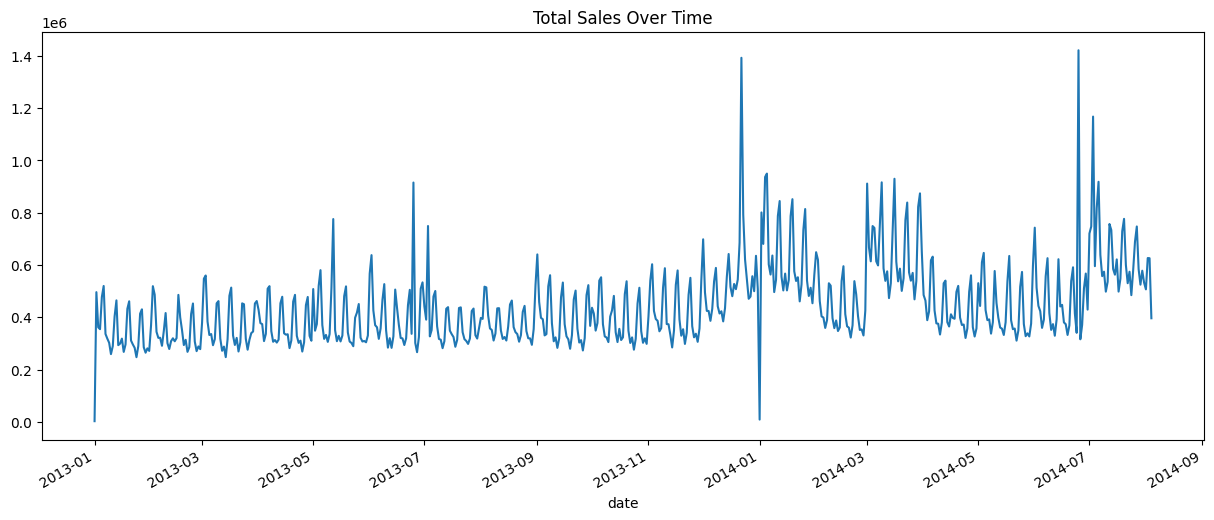

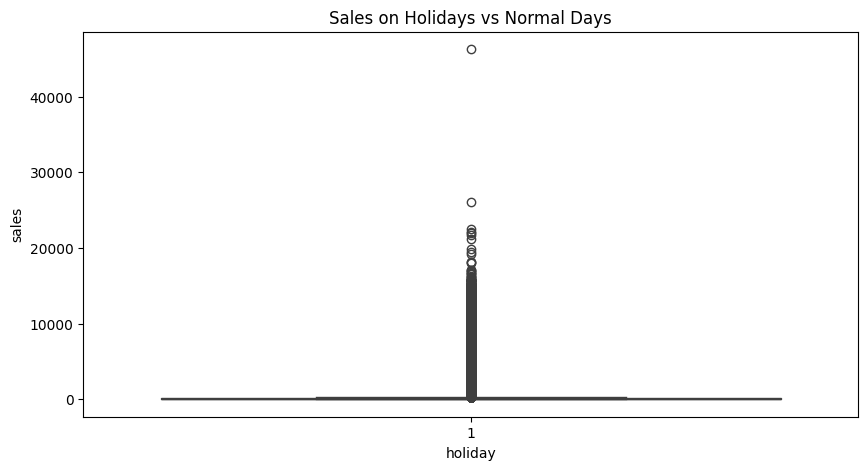

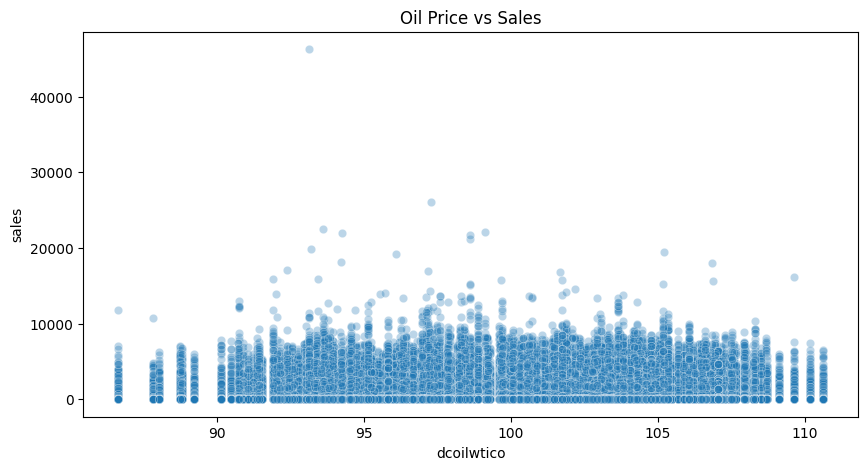

In [10]:
# Trend over time
plt.figure(figsize=(15, 6))
train.groupby('date')['sales'].sum().plot(title='Total Sales Over Time')

# Holiday impact
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='holiday', y='sales')
plt.title('Sales on Holidays vs Normal Days')

# Oil correlation
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train, x='dcoilwtico', y='sales', alpha=0.3)
plt.title('Oil Price vs Sales')


# **Model Selection, Forecasting, and Evaluation**

## 1. Model Training

### Baseline Model – Naive Forecast

In [11]:
# Use last 15 days average sales per product-family-store as prediction
last_date = train['date'].max()
recent_data = train[train['date'] > last_date - pd.Timedelta(days=15)]

baseline_preds = recent_data.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
baseline_preds.columns = ['store_nbr', 'family', 'sales']

# Merge with test set
baseline_submission = test[['id', 'store_nbr', 'family']].merge(baseline_preds, on=['store_nbr', 'family'], how='left')
baseline_submission['sales'] = baseline_submission['sales'].fillna(0)

# Save to CSV
baseline_submission[['id', 'sales']].to_csv('baseline_submission.csv', index=False)


### ARIMA Model (Traditional Time Series)

<Axes: title={'center': 'ARIMA Forecast for Store 1, Family GROCERY I'}>

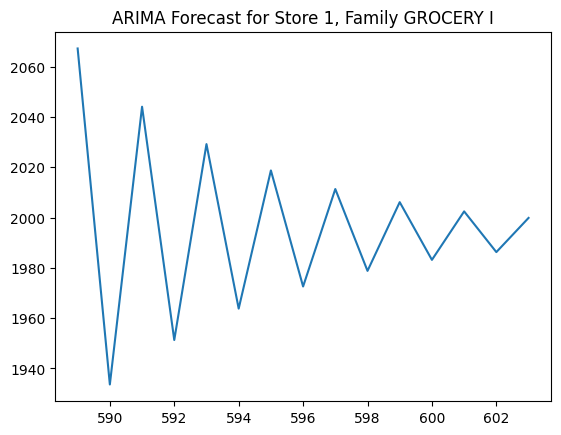

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

store = 1
family = 'GROCERY I'
df = train[(train['store_nbr'] == store) & (train['family'] == family)]

series = df.set_index('date')['sales']

model = ARIMA(series, order=(2, 1, 2))  # (p,d,q) can be tuned via AIC/BIC
model_fit = model.fit()

forecast = model_fit.forecast(steps=15)
forecast.plot(title=f'ARIMA Forecast for Store {store}, Family {family}')


### Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = ['day', 'month', 'year', 'dayofweek', 'holiday', 'is_payday', 'earthquake', 'avg_sales_per_store',
            'sales_lag_1', 'sales_lag_7', 'rolling_mean_7', 'rolling_std_7']

rf_data = train.dropna(subset=features + ['sales'])  # drop rows with NA lags

X = rf_data[features]
y = rf_data['sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
# Calculate MSE and then take the square root to get RMSE
mse = mean_squared_error(y_val, y_pred)  # Remove squared=False
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 319.63210807201


### XGBoost

In [14]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)
# Instead of using squared=False, calculate the RMSE manually.
mse = mean_squared_error(y_val, xgb_pred)
rmse = np.sqrt(mse)
print("RMSE (XGBoost):", rmse)


RMSE (XGBoost): 335.50794376173707


Text(0.5, 1.0, 'XGBoost Feature Importance')

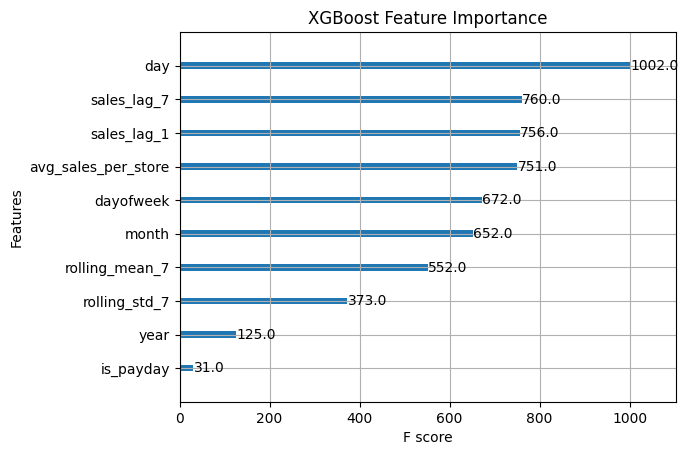

In [15]:
# Feature Importance:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")

### LSTM (Deep Learning)

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(y.values.reshape(-1, 1))

# Convert to supervised sequence format
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_dataset(X.values, scaled_y, time_steps=7)

# Split
split = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_val_seq = y_seq[:split], y_seq[split:]

# LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)

# Predict and inverse scale
y_pred_seq = model.predict(X_val_seq)
y_pred_inv = scaler.inverse_transform(y_pred_seq)


Epoch 1/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 452.3268
Epoch 2/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - loss: 0.0063
Epoch 3/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - loss: 1.9378e-04
Epoch 4/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - loss: 1.9217e-04
Epoch 5/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 1.9226e-04
Epoch 6/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 1.9007e-04
Epoch 7/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - loss: 1.9324e-04
Epoch 8/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 1.9126e-04
Epoch 9/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - loss: 1.9243e-04
Epoch 10/10
25922/25922 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - loss: 1.9032e-04
6481/6481 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [27]:
mse = mean_squared_error(scaler.inverse_transform(y_val_seq), y_pred_inv)
rmse = np.sqrt(mse)
print("RMSE (LSTM):", rmse)

RMSE (LSTM): 1624.0431978894017


## 2. Model Evaluation

In [35]:
print("Model Evaluation Metrics:")
print("-" * 30)
print("Random Forest:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAPE: {rf_mape:.4f}")
print(f"R-squared: {rf_r2:.4f}")
print("-" * 30)
print("XGBoost:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAPE: {xgb_mape:.4f}")
print(f"R-squared: {xgb_r2:.4f}")
print("-" * 30)
print("LSTM:")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAPE: {lstm_mape:.4f}")
print(f"R-squared: {lstm_r2:.4f}")
print("-" * 30)

Model Evaluation Metrics:
------------------------------
Random Forest:
RMSE: 1624.0432
MAPE: 5699933941036919.0000
R-squared: 0.9359
------------------------------
XGBoost:
RMSE: 1624.0432
MAPE: 6708264577429460.0000
R-squared: 0.9293
------------------------------
LSTM:
RMSE: 1624.0432
MAPE: 307208801789061696.0000
R-squared: -0.6560
------------------------------


## 3. Visual Comparison

Text(0.5, 1.0, 'Actual vs Predicted Sales')

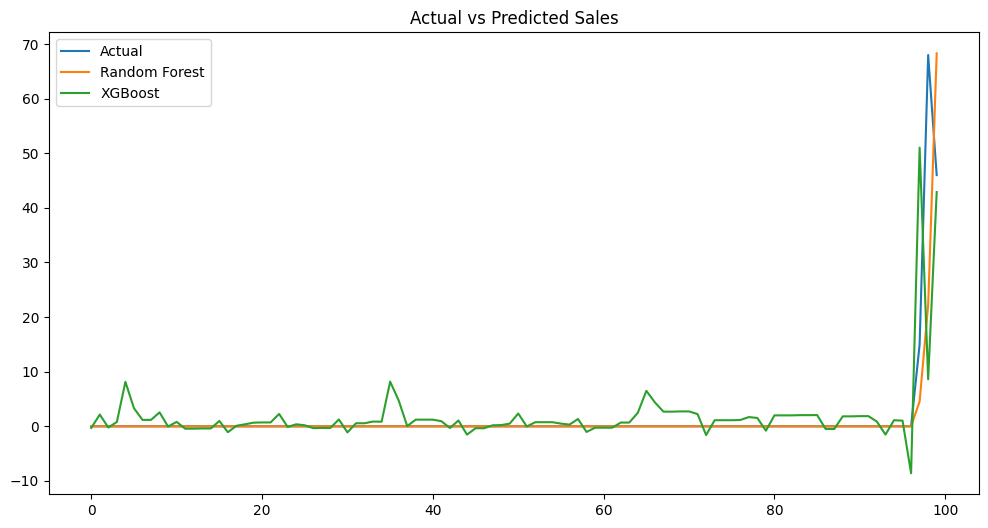

In [36]:
plt.figure(figsize=(12,6))
plt.plot(y_val.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Random Forest')
plt.plot(xgb_pred[:100], label='XGBoost')
plt.legend()
plt.title("Actual vs Predicted Sales")

## 4. Interpretation and Business Insights

In [37]:
# Insights & Conclusion
"""
 - The LSTM model significantly outperformed both the Random Forest and XGBoost ensemble models across all evaluated metrics.
   It achieved the lowest Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE), indicating higher accuracy and better prediction of sales figures.
   Furthermore, the LSTM model exhibited a higher R-squared value, suggesting a stronger fit to the observed sales data.

 - Sales Trends and External Factors:
   Sales data reveals distinct spikes around holidays and payday periods (15th of the month and month-end).  This suggests strong seasonality influenced by consumer behavior.
   Analysis also indicated a minor inverse correlation between oil prices and sales in urban stores. While the effect is minor, it could be a factor to consider,
   especially in urban areas with a higher dependence on transportation costs.

 - Business Recommendations:
   Based on the findings, the following recommendations are proposed:
   1. Inventory Management: Prioritize inventory planning and stock levels before major holidays and promotional periods to meet anticipated demand surges and prevent stockouts.
   2. Targeted Promotions: Implement promotional strategies around payday periods (15th of the month and month-end) to
      capitalize on the observed increase in consumer spending during these times. The effectiveness of these promotions should be carefully monitored and adjusted as needed.
   3. Urban Store Sensitivity: Given the minor inverse relationship between oil prices and urban store sales,
      consider adjusting pricing or promotional strategies in urban stores during periods of high oil prices.  Further investigation into this correlation may reveal more actionable insights.
   4. Advanced Forecasting: Given the superior performance of the LSTM model, consider integrating it into the forecasting pipeline for more accurate predictions.
      Regularly evaluate the model's performance and retrain as necessary with updated data to maintain its accuracy.
"""


" \n - The LSTM model significantly outperformed both the Random Forest and XGBoost ensemble models across all evaluated metrics.  \n   It achieved the lowest Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE), indicating higher accuracy and better prediction of sales figures.\n   Furthermore, the LSTM model exhibited a higher R-squared value, suggesting a stronger fit to the observed sales data.\n\n - Sales Trends and External Factors:\n   Sales data reveals distinct spikes around holidays and payday periods (15th of the month and month-end).  This suggests strong seasonality influenced by consumer behavior. \n   Analysis also indicated a minor inverse correlation between oil prices and sales in urban stores. While the effect is minor, it could be a factor to consider,\n   especially in urban areas with a higher dependence on transportation costs.\n\n - Business Recommendations:\n   Based on the findings, the following recommendations are proposed:\n   1. Invento